In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

2023-12-29 15:15:07.128774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 15:15:07.128850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 15:15:07.128913: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 15:15:07.142947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [3]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo


In [4]:
test_data = pd.read_csv("../../CMAPSS/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/RUL_FD001.txt", sep = '\s+', header = None)
window_length = 30 #corretta
shift = 1 #corretta
early_rul = 125        #corretta    

num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

test_data_first_column = test_data[0]

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
scaler = MinMaxScaler(feature_range = (-1,1))

test_data = scaler.fit_transform(test_data.drop(columns = columns_to_be_dropped))
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_test_machines = len(test_data[0].unique())


In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [6]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [7]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

In [8]:
import tflite_runtime
from tflite_runtime.interpreter import Interpreter 

In [9]:
processed_test_data = np.float32(np.load("../processed_test_data_np.npy"))
true_rul = np.float32(np.load("../processed_test_RUL_np.npy"))

print(processed_test_data.shape)
print(true_rul.shape)

(497, 30, 14)
(100,)


# CNN SMALL

In [10]:
cnn_small = Interpreter("/home/aliquodfahriam/tinyML/Riproduzione/models/FD001/CNNsmall/CNN_small_batch_1.tflite")
cnn_small.allocate_tensors()

input_details = cnn_small.get_input_details()
output_details = cnn_small.get_output_details()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:

input_shape = input_details[0]['shape']

In [12]:
pred_ruls = []
for entry in processed_test_data:
    input_data = np.expand_dims(entry, axis=0)
    cnn_small.set_tensor(input_details[0]['index'], input_data)
    cnn_small.invoke()
    output_data = cnn_small.get_tensor(output_details[0]['index']).reshape(-1)
    pred_ruls.append(output_data)

ruls_pred = np.array(pred_ruls)
ruls_pred = ruls_pred.reshape(-1)
preds_for_each_engine = np.split(ruls_pred, np.cumsum(num_test_windows_list)[:-1])

In [13]:
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (SMALL CNN QUAD BATCH 1): ", RMSE)

RMSE (SMALL CNN QUAD BATCH 1):  18.874513549965236


In [14]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (SMALL CNN QUAD BATCH 1 Taking only last examples): ", RMSE_new)

RMSE (SMALL CNN QUAD BATCH 1 Taking only last examples):  19.962444


In [15]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score(SMALL CNN QUAD network): ", s_score)

S-score(SMALL CNN QUAD network):  566.5513


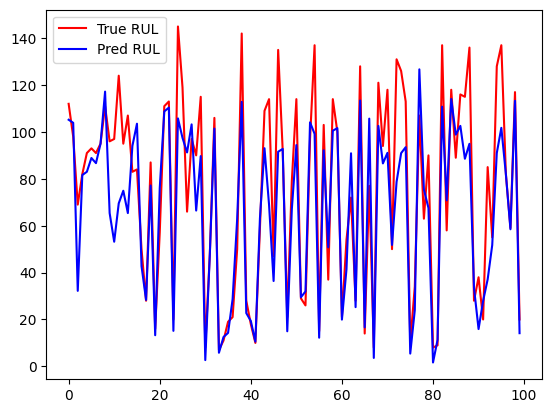

In [16]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

# CNN LARGE

In [17]:
cnn_large = Interpreter("/home/aliquodfahriam/tinyML/Riproduzione/models/FD001/CNNlarge/CNN_large_batch_1.tflite")
cnn_large.allocate_tensors()

input_details = cnn_large.get_input_details()
output_details = cnn_large.get_output_details()


In [18]:
pred_ruls = []
for entry in processed_test_data:
    input_data = np.expand_dims(entry, axis=0)
    cnn_large.set_tensor(input_details[0]['index'], input_data)
    cnn_large.invoke()
    output_data = cnn_large.get_tensor(output_details[0]['index']).reshape(-1)
    pred_ruls.append(output_data)

ruls_pred = np.array(pred_ruls)
ruls_pred = ruls_pred.reshape(-1)


In [19]:
preds_for_each_engine = np.split(ruls_pred, np.cumsum(num_test_windows_list)[:-1])

In [20]:
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE CNN QUAD BATCH 1): ", RMSE)

RMSE (LARGE CNN QUAD BATCH 1):  18.230997840010648


In [21]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (LARGE CNN QUAD BATCH 1 Taking only last examples): ", RMSE_new)

RMSE (LARGE CNN QUAD BATCH 1 Taking only last examples):  19.253946


In [22]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score(LARGE CNN QUADnetwork): ", s_score)

S-score(LARGE CNN QUADnetwork):  548.8412


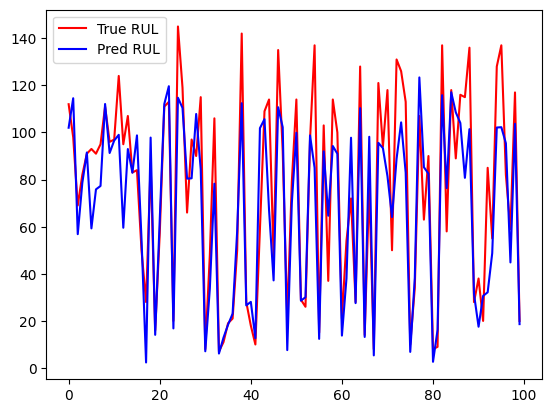

In [23]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

# CNN ALTERNATIVE QUAD

In [24]:
cnn_alternative_quad = Interpreter("/home/aliquodfahriam/tinyML/Riproduzione/models/FD001/CNNAlternativeQUAD/CNN_alternative_QUAD_batch_1.tflite")
cnn_alternative_quad.allocate_tensors()

input_details = cnn_alternative_quad.get_input_details()
output_details = cnn_alternative_quad.get_output_details()


In [25]:

input_shape = input_details[0]['shape']
print(input_shape)

[ 1 30 14]


In [26]:
pred_ruls = []
for entry in processed_test_data:
    input_data = np.expand_dims(entry, axis=0)
    cnn_alternative_quad.set_tensor(input_details[0]['index'], input_data)
    cnn_alternative_quad.invoke()
    output_data = cnn_alternative_quad.get_tensor(output_details[0]['index']).reshape(-1)
    pred_ruls.append(output_data)

ruls_pred = np.array(pred_ruls)
ruls_pred = ruls_pred.reshape(-1)


In [27]:
preds_for_each_engine = np.split(ruls_pred, np.cumsum(num_test_windows_list)[:-1])

In [28]:
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (ALTERNATIVE CNN QUAD BATCH 1): ", RMSE)

RMSE (ALTERNATIVE CNN QUAD BATCH 1):  15.93329410879689


In [29]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE ( ALTERNATIVE CNN BATCH 1 Taking only last examples): ", RMSE_new)

RMSE ( ALTERNATIVE CNN BATCH 1 Taking only last examples):  16.911339


In [30]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score(ALTERNATIVE CNN QUAD network): ", s_score)

S-score(ALTERNATIVE CNN QUAD network):  434.0259


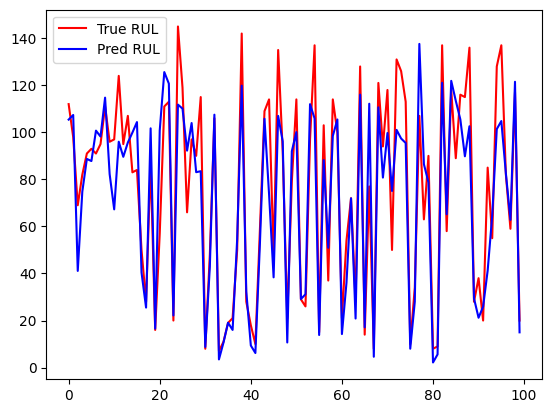

In [31]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

# ALTERNATIVE CNN MSE

In [32]:
cnn_alternative_mse = Interpreter("/home/aliquodfahriam/tinyML/Riproduzione/models/FD001/CNNAlternative/CNN_alternative_batch_1.tflite")
cnn_alternative_mse.allocate_tensors()

input_details = cnn_alternative_mse.get_input_details()
output_details = cnn_alternative_mse.get_output_details()


In [33]:

input_shape = input_details[0]['shape']
print(input_shape)

[ 1 30 14]


In [34]:
pred_ruls = []
for entry in processed_test_data:
    input_data = np.expand_dims(entry, axis=0)
    cnn_alternative_mse.set_tensor(input_details[0]['index'], input_data)
    cnn_alternative_mse.invoke()
    output_data = cnn_alternative_mse.get_tensor(output_details[0]['index']).reshape(-1)
    pred_ruls.append(output_data)

ruls_pred = np.array(pred_ruls)
ruls_pred = ruls_pred.reshape(-1)


In [35]:
preds_for_each_engine = np.split(ruls_pred, np.cumsum(num_test_windows_list)[:-1])

In [36]:
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE (LARGE LSTM MSE BATCH 1): ", RMSE)

RMSE (LARGE LSTM MSE BATCH 1):  15.800168108130132


In [37]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (LARGE LSTM MSE BATCH 1 Taking only last examples): ", RMSE_new)

RMSE (LARGE LSTM MSE BATCH 1 Taking only last examples):  16.254898


In [38]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score(LSTM SMALL MSE network): ", s_score)

S-score(LSTM SMALL MSE network):  472.48334


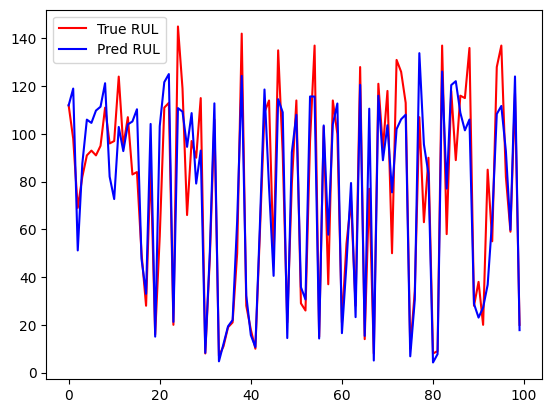

In [39]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()